In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

Situation: in a randomized, controlled trial, hospital patients are assigned to treatment randomly.

X is 1 if treated, 0 if untreated.

The medication changes their blood pressure by -10 points with a standard deviation of 10.

## Z Relevant to defining Y but not X (not a confounder)

In [49]:
num = 1000
np.random.seed(0)
X_treatment = np.random.binomial(1, 0.5, (num,))
Z_before = np.random.uniform(100, 150, (num,))
Y_after = Z_before - 10 * X_treatment + np.random.normal(0, 10, (num,))

<Axes: >

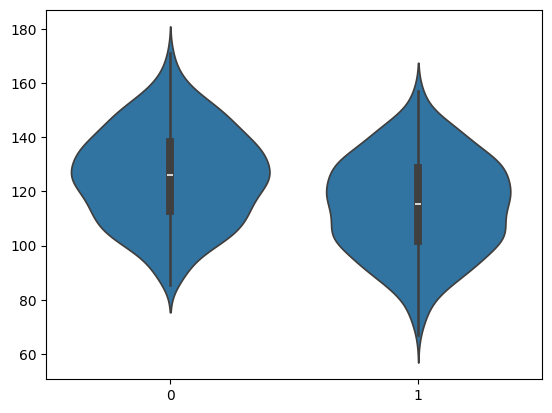

In [50]:
sns.violinplot(x = X_treatment, y = Y_after)

### This violin plot is causally accurate: it shows the treatment decreasing blood pressure

## Z relevant to defining Y and Z (confounder)

In [72]:
num = 1000
np.random.seed(0)
Z_before = np.random.uniform(100, 150, (num,))
X_treatment = 1 * (Z_before > 120) # All patients with Z_before > 120 are treated.
Y_after = Z_before - 10 * X_treatment + np.random.normal(0, 10, (num,))

<Axes: >

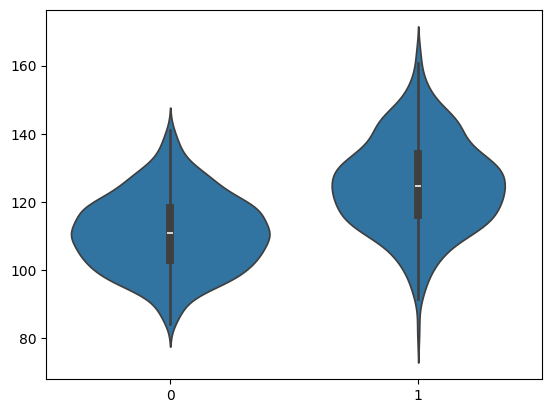

In [73]:
sns.violinplot(x = X_treatment, y = Y_after)

### This violin plot is accurate to the data, but causally inaccurate: it shows the treatment increasing blood pressure.

We can't tell it is causally inaccurate from the data alone, because we don't know if Z should be included in our analysis.

In [71]:
df.iloc[0:5]

,X,Z,Y
0,1,127.440675,121.725823
1,1,135.759468,111.898131
2,1,130.138169,109.109056
3,0,127.244159,110.922059
4,1,121.182740,94.027143


In [83]:
num = 1000
np.random.seed(0)
X_treatment = np.random.binomial(1, 0.5, (num,))
Z_before = np.random.uniform(100, 150, (num,))
Y_after = Z_before - 10 * X_treatment + np.random.normal(0, 10, (num,))

In [85]:
df_XY = pd.DataFrame({"X": X_treatment, "Y": Y_after})
dtr = DecisionTreeRegressor(max_depth = 3)
dtr.fit(df_XY[["X"]], df_XY.Y)
root_mean_squared_error(dtr.predict(df_XY[["X"]]), df_XY.Y)

17.5011243146738

## X tree number one: less accurate in terms of RMSE, more correct causally

If we include Z, then we can get a smaller RMSE:

In [52]:
print(export_text(dtr, feature_names = ["X"]))

|--- X <= 0.50
|   |--- value: [125.71]
|--- X >  0.50
|   |--- value: [114.91]



In [98]:
df_XYZ = pd.DataFrame({"X": X_treatment, "Y": Y_after, "Z": Z_before})
X_treatment = np.random.binomial(1, 0.5, (num,))
Z_before = np.random.uniform(100, 150, (num,))
Y_after = Z_before - 10 * X_treatment + np.random.normal(0, 10, (num,))
dtr = DecisionTreeRegressor(max_depth = 3)
dtr.fit(df_XYZ[["X", "Z"]], df_XYZ.Y)
root_mean_squared_error(dtr.predict(df_XYZ[["X", "Z"]]), df_XYZ.Y)

10.736232321712652

In [99]:
print(export_text(dtr, feature_names = ["X", "Z"]))

|--- Z <= 124.48
|   |--- Z <= 113.17
|   |   |--- X <= 0.50
|   |   |   |--- value: [106.54]
|   |   |--- X >  0.50
|   |   |   |--- value: [95.95]
|   |--- Z >  113.17
|   |   |--- X <= 0.50
|   |   |   |--- value: [117.82]
|   |   |--- X >  0.50
|   |   |   |--- value: [107.49]
|--- Z >  124.48
|   |--- Z <= 136.60
|   |   |--- X <= 0.50
|   |   |   |--- value: [130.38]
|   |   |--- X >  0.50
|   |   |   |--- value: [122.38]
|   |--- Z >  136.60
|   |   |--- X <= 0.50
|   |   |   |--- value: [145.18]
|   |   |--- X >  0.50
|   |   |   |--- value: [134.86]



This time, all patients with Z_before > 120 are treated.

<Axes: >

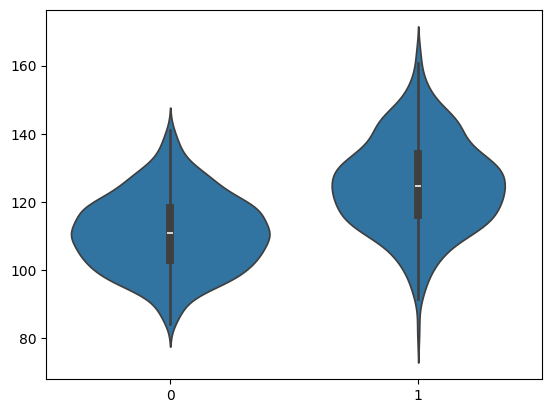

In [55]:
num = 1000
np.random.seed(0)
Z_before = np.random.uniform(100, 150, (num,))
X_treatment = 1 * (Z_before > 120)
Y_after = Z_before - 10 * X_treatment + np.random.normal(0, 10, (num,))
sns.violinplot(x = X_treatment, y = Y_after)

### We get a lower RMSE, so the tree is more "accurate," yet the tree is causally wrong: it shows treatment as raising the Y_after blood pressure
### In fact, the decision tree can't tell that there is a missing confounder Z (the blood pressure before)

## X tree number two: more accurate in terms of RMSE, less causally correct

In [102]:
df_XY = pd.DataFrame({"X": X_treatment, "Y": Y_after})
dtr = DecisionTreeRegressor(max_depth = 3)
dtr.fit(df_XY[["X"]], df_XY.Y)
root_mean_squared_error(dtr.predict(df_XY[["X"]]), df_XY.Y)

12.417560168686471

In [103]:
print(export_text(dtr, feature_names = ["X"]))

|--- X <= 0.50
|   |--- value: [110.93]
|--- X >  0.50
|   |--- value: [125.13]



In [104]:
df_XYZ = pd.DataFrame({"X": X_treatment, "Y": Y_after, "Z": Z_before})
dtr = DecisionTreeRegressor(max_depth = 3)
dtr.fit(df_XYZ[["X", "Z"]], df_XYZ.Y)
root_mean_squared_error(dtr.predict(df_XYZ[["X", "Z"]]), df_XYZ.Y)

9.571281756171958

Treatment is likely irrelevant in the tree because it is just a marker for a particular value of Z.

In [105]:
print(export_text(dtr, feature_names = ["X", "Z"]))

|--- Z <= 133.83
|   |--- Z <= 109.02
|   |   |--- Z <= 100.10
|   |   |   |--- value: [121.72]
|   |   |--- Z >  100.10
|   |   |   |--- value: [105.31]
|   |--- Z >  109.02
|   |   |--- Z <= 129.61
|   |   |   |--- value: [114.79]
|   |   |--- Z >  129.61
|   |   |   |--- value: [121.25]
|--- Z >  133.83
|   |--- Z <= 146.13
|   |   |--- Z <= 137.44
|   |   |   |--- value: [125.50]
|   |   |--- Z >  137.44
|   |   |   |--- value: [131.48]
|   |--- Z >  146.13
|   |   |--- Z <= 148.74
|   |   |   |--- value: [139.13]
|   |   |--- Z >  148.74
|   |   |   |--- value: [144.60]



### Conclusion: The second tree with just X is "inaccurate" causally, but in terms of RMSE it gets better results than the first tree with just X.  This suggests that causal correctness and RMSE are not the same.

Using traditional data science terms like accuracy, MSE, RMSE, etc. we cannot say what the problem is.

It's "inaccurate" in a **causal** sense: X causes a decrease in blood pressure.  That can't be seen from the data.  But it can be seen from the code that generates the data.  So we are really saying that it is **inaccurate with respect to the code that generated the example.**